# Simulations for M5 single-strain model

In [1]:
from cobra.io import read_sbml_model

m5 = read_sbml_model("GEMs/M5_curated.xml")

In [2]:
uptake_KO = ["XYLANabc", "XYLabc", "XYLtex"]

for rx in uptake_KO:
    m5.reactions.get_by_id(rx).bounds = (0, 0)

# restrict rate of xylose uptake
m5.reactions.XYLt2.bounds = (0, 0.25)

In [3]:
from utils.flux_coupling import add_ratio_constraint_cobra

add_ratio_constraint_cobra(m5, "BUTt" , "ACtr",  0.71, r_num_reverse=False, r_den_reverse=False)

Metabolite identifier,ratio_BUTt_ACtr
Name,
Memory address,0x1046cb640
Formula,None
Compartment,pseudo
In 2 reaction(s),"BUTt, ACtr"


## Static sim.

In [97]:
from utils import static_sim

medium = static_sim.get_specific_medium(m5, {"EX_xylan4_e": 0, "EX_xylan8_e": 1, "EX_nh4_e": 10, "EX_h_e": 5, "EX_h2o_e": 10})

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [78]:
from cobra.flux_analysis import pfba

with m5:
    m5.medium = medium
    summary = m5.summary()
    solution = m5.optimize()
    pfba_solution = pfba(m5)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [79]:
summary

Metabolite,Reaction,Flux,C-Number,C-Flux
arg__L_e,EX_arg__L_e,0.1,6,1.06%
asp__L_e,EX_asp__L_e,0.1,4,0.71%
ca2_e,EX_ca2_e,0.0005882,0,0.00%
cl_e,EX_cl_e,0.0005882,0,0.00%
cobalt2_e,EX_cobalt2_e,1.13E-05,0,0.00%
cu2_e,EX_cu2_e,8.012E-05,0,0.00%
cys__L_e,EX_cys__L_e,0.01041,3,0.06%
dcyt_e,EX_dcyt_e,0.1,9,1.59%
fe2_e,EX_fe2_e,0.0007588,0,0.00%
fe3_e,EX_fe3_e,0.0008823,0,0.00%


In [80]:
import escher
from escher import Builder

builder = Builder(map_json='escher_maps/m5_new_map.json', model=m5, height=600)

In [81]:
builder.reaction_data = pfba_solution.fluxes

In [82]:
builder

Builder(height=600, reaction_data={'12DGR120tipp': 0.0, '12DGR140tipp': 0.0, '12DGR141tipp': 0.0, '12DGR160tip…

In [83]:
static_sim.read_production_rates(pfba_solution, production_reactions=["EX_but_e", "EX_ac_e", "EX_etoh_e", "EX_btoh_e"])

Production fluxes:
EX_but_e     0.000000
EX_ac_e      4.169278
EX_etoh_e    0.000000
EX_btoh_e   -0.000000
Name: fluxes, dtype: float64


Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.
Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


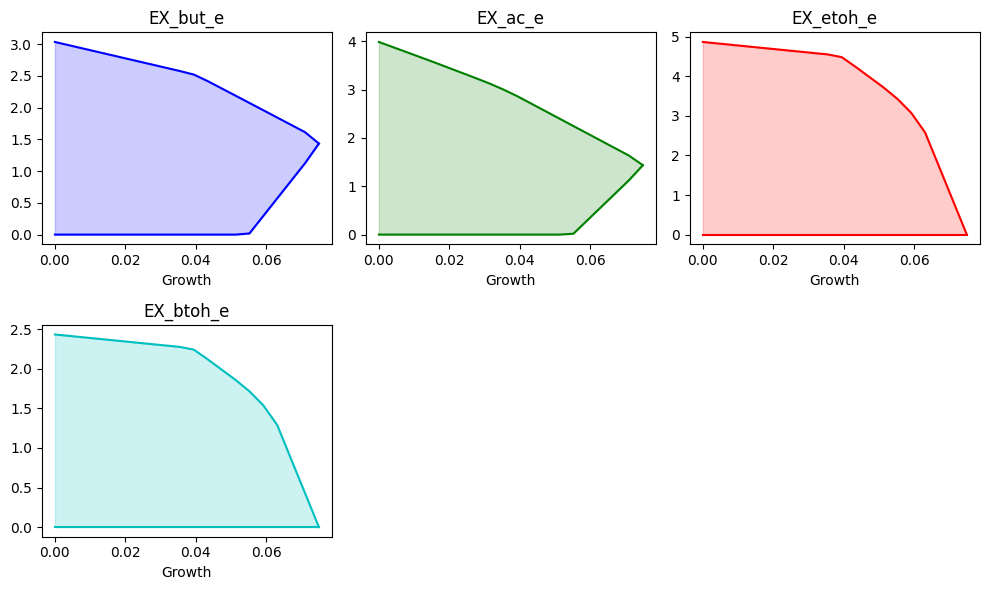

In [98]:
from utils import static_sim

prod_reactions = ["EX_but_e", "EX_ac_e", "EX_etoh_e", "EX_btoh_e"]

static_sim.plot_flux_envelopes(m5, medium=medium, reactions=prod_reactions)

## Additional constraints to enforce xylose secretion

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


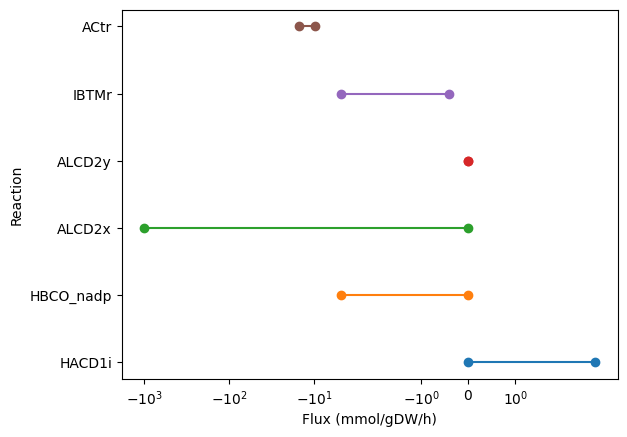

In [6]:
interesting_rx = ["HACD1i", "HBCO_nadp", "ALCD2x", "ALCD2y", "IBTMr", "ACtr"]

static_sim.plot_flux_ranges(model=m5, medium=medium, reactions=interesting_rx)

In [3]:
from cobra.flux_analysis import pfba

with m5:
    m5.medium = medium
    
    uptake_KO = ["XYLANabc", "XYLabc", "XYLtex"]
    for rx in uptake_KO:
        m5.reactions.get_by_id(rx).bounds = (0, 0)
    
    m5.reactions.XYLt2.bounds = (0, 4) # restrict rate of xylose uptake

    summary = m5.summary()
    pfba_solution = pfba(m5)

Could not identify an external compartment by name and choosing one with the most boundary reactions. That might be complete nonsense or change suddenly. Consider renaming your compartments using `Model.compartments` to fix this.


In [4]:
import escher
from escher import Builder

builder = Builder(map_json='escher_maps/substrate_uptake_map.json', model=m5, height=600)
builder.reaction_data = pfba_solution.fluxes
builder

Builder(height=600, reaction_data={'12DGR120tipp': 0.0, '12DGR140tipp': 0.0, '12DGR141tipp': 0.0, '12DGR160tip…

## Dynamic sim.

In [4]:
import pandas as pd

media_db = pd.read_csv("medium.tsv", sep="\t")

m5_med = media_db[media_db["medium"] == "m5_med"]

UNLIMITED_METABOLITES = ['ca2_e', 'cl_e', 'cobalt2_e', 'cu2_e', 'fe2_e', 'fe3_e','h_e', 'k_e', 'h2o_e', 'mg2_e', 
                    'mn2_e', 'mobd_e', 'na1_e', 'nh4_e', 'ni2_e', 'pi_e', 'so4_e', 'zn2_e']

medium = [str(m+"_e") for m in m5_med["compound"].tolist()]
added_metabilotes = set(medium) - set(UNLIMITED_METABOLITES)
added_metabilotes = {k:0.5 for k in added_metabilotes}

added_metabilotes["xylan8_e"] = 2.5
added_metabilotes["xylan4_e"] = 0

In [8]:
from utils.kinetic_params import M5_VMAX, M5_KM, M5_HILL

M5_KM["EX_xylan8_e"] = 1
M5_VMAX["EX_xylan8_e"] = 6

In [9]:
from utils.comets_functions import single_strain

sim = single_strain(model=m5, medium=added_metabilotes, sim_time=144, km_dict=M5_KM, vmax_dict=M5_VMAX, hill_dict=M5_HILL)


Running COMETS simulation ...
Done!


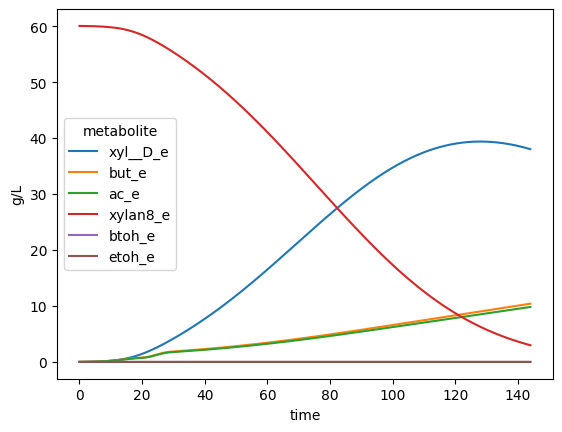

In [10]:
import seaborn as sns
from utils.comets_functions import plot_metabolites, plot_biomass, plot_reaction_flux

metabolites = ["xyl__D_e", "etoh_e", "but_e", "btoh_e", "ac_e", "xylan8_e"]

plot_metabolites(sim, metabolites)

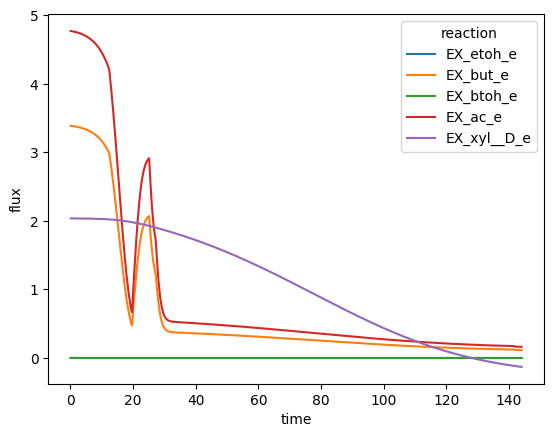

In [11]:
production_reactions = ["EX_etoh_e", "EX_but_e", "EX_btoh_e", "EX_ac_e", "EX_xyl__D_e"]

plot_reaction_flux(sim, production_reactions, "M5")

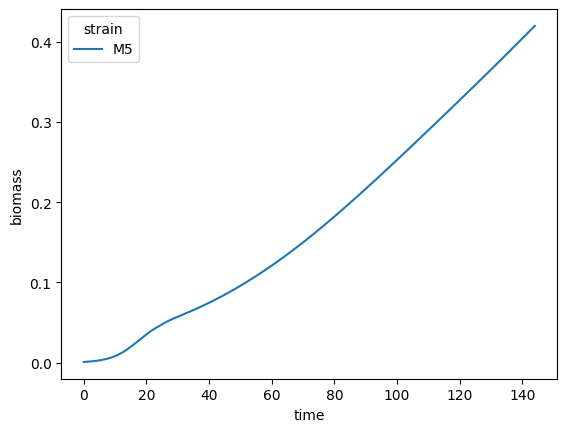

In [10]:
plot_biomass(sim)

In [13]:
from escher import Builder

#animation = Builder(map_json='escher_maps/substrate_uptake_map.json', model=m5, height=600)
animation = Builder(map_json='escher_maps/m5_new_map.json', model=m5, height=600)

In [15]:
from time import sleep
from tqdm.notebook import tqdm

fluxes = sim.fluxes_by_species["M5"].drop(columns=["x", "y"])
melted_fluxes = fluxes.melt(id_vars="cycle", value_name="flux", var_name="reaction")

n_cycles = fluxes.shape[0]

for i in tqdm(range(n_cycles)):
    point_in_time = melted_fluxes[melted_fluxes["cycle"] == i]
    flux_series = point_in_time.set_index("reaction")["flux"]
    animation.reaction_data = flux_series
    sleep(0.1)

  0%|          | 0/1400 [00:00<?, ?it/s]

In [14]:
animation

Builder(height=600)